In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

[*********************100%***********************]  1 of 1 completed


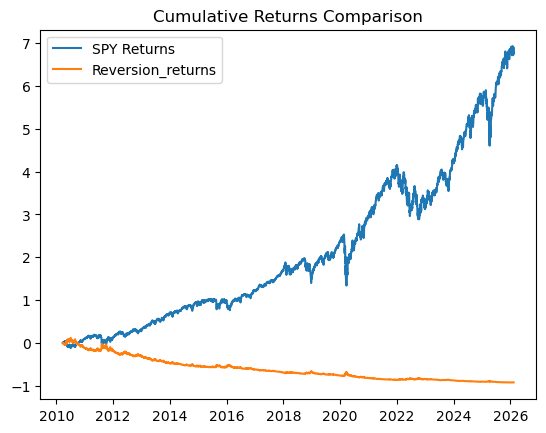

Price,Close,High,Low,Open,Volume,returns,signal,strategy,Asset_returns,strategy_returns
Date,,,,,,,,,,
2010-03-22,87.834053,87.992263,86.817020,86.869755,184477800,1.233944,-1.0,NaN,NaN,NaN
2010-03-23,88.451797,88.527132,87.675834,87.962113,182941600,1.249656,-1.0,-1.0,0.007033,-0.007033
2010-03-24,88.022408,88.466892,87.073180,88.120348,196072600,1.238735,-1.0,-1.0,0.002144,-0.002213
2010-03-25,87.879250,89.024352,87.773780,88.617538,223396300,1.235094,-1.0,-1.0,0.000515,-0.000590
2010-03-26,87.826515,88.459333,87.479971,88.044990,205808500,1.233753,-1.0,-1.0,-0.000086,0.000010
...,...,...,...,...,...,...,...,...,...,...
2026-02-06,690.619995,692.309998,680.849976,681.460022,89127600,16.565017,-1.0,-1.0,6.862782,-0.920621
2026-02-09,693.950012,695.869995,688.340027,689.419983,73885200,16.649711,-1.0,-1.0,6.900694,-0.921004
2026-02-10,692.119995,696.539978,691.659973,694.950012,65185700,16.603167,-1.0,-1.0,6.879859,-0.920795


In [2]:
ticker = "SPY"
LOOKBACK = -4000

def get_data():
    df = yf.download(ticker, period = '30y', auto_adjust=True, interval='1d')
    df.sort_index(inplace=True)
    df.columns = df.columns.get_level_values(0)
    df["returns"] = (1 + df['Close'].pct_change()).cumprod() - 1

    return df.iloc[LOOKBACK:,:]
    
def strategy(df):
    # 1. Create purely Buy (1) and Sell (-1) signals, use NaN for "do nothing"
    conditions = [
        (df['returns'] > 0).astype(bool), # Condition 1: Short
        (df['returns'] < 0).astype(bool)   # Condition 2: Long
    ]
    choices = [-1, 1]
    
    # Use np.select to assign 1 or -1, but default to NaN (np.nan) instead of 0
    df['signal'] = np.select(conditions, choices, default=np.nan)

    # 2. Forward Fill (The Memory)
    # This says: "If today is NaN, copy yesterday's position."
    df['strategy'] = df['signal'].ffill()

    # 3. Handle the start (replace initial NaNs with 0)
    df['strategy'] = df['strategy'].fillna(0)

    # 4. Shift to trade "tomorrow"
    df['strategy'] = df['strategy'].shift(1)

    return df

def test_strategy(df):
    df['Asset_returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['strategy_returns'] = (1 + df['Close'].pct_change() * df['strategy']).cumprod() - 1

    plt.figure()
    plt.plot(df['Asset_returns'], label=f'{ticker} Returns')
    plt.plot(df['strategy_returns'], label='Reversion_returns')
    plt.legend()
    plt.title('Cumulative Returns Comparison')
    plt.show()

    return df

def main():
    df = get_data()
    df = strategy(df)
    df = test_strategy(df)
    return df

main()